<a href="https://colab.research.google.com/github/ellieytc/CaseStudy.DeepLearning/blob/master/Food_originCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Aug 18 10:07:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## download data

In [2]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Tibame/dataset/food_img.zip'

zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.chdir('/tmp/food_img')
os.listdir('/tmp/food_img')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


['chicken',
 'cabbage',
 'tomato',
 'cucumber',
 'radish',
 'apple',
 'carrot',
 'potato',
 'mushroom',
 'egg']

## import library

In [4]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.preprocessing import image
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random, os, pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## data preprocessing

In [5]:
def read_and_process_image(data_dir,width=32, height=32, channels=3, preprocess=False):
    train_classes= [data_dir + "/" +  i for i in os.listdir(data_dir) ]
    train_images = []
    for train_class in train_classes:
        train_images= train_images + [train_class + "/" + i for i in os.listdir(train_class)]
    random.shuffle(train_images)
    print(train_images[0:10])

    def read_image(file_path, preprocess):
        img = image.load_img(file_path, target_size=(height, width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        # if preprocess:
            # x = preprocess_input(x)
        return x
    
    def prep_data(images, preprocess):
        count = len(images)
        data = np.ndarray((count, height, width, channels), dtype = np.float32)
        print(data.shape)
        for i, image_file in enumerate(images):
            image = read_image(image_file, preprocess)
            data[i] = image
        return data

    def read_labels(file_path):
        labels = []
        for i in file_path:
            if 'apple' in i:
                label = 0
            elif 'cabbage' in i:
                label = 1
            elif 'carrot' in i:
                label = 2
            elif 'chicken' in i:
                label = 3
            elif 'cucumber' in i:
                label = 4
            elif 'egg' in i:
                label = 5
            elif 'mushroom' in i:
                label = 6
            elif 'potato' in i:
                label = 7
            elif 'radish' in i:
                label = 8
            elif 'tomato' in i:
                label = 9
            labels.append(label)
        
        return labels
    
    X = prep_data(train_images, preprocess)
    labels = read_labels(train_images)
    
    assert X.shape[0] == len(labels)
    
    #print("Train shape: {}".format(X.shape))
    #print("Train shape: {}".format(len(labels)))
    return X, labels

x,y = read_and_process_image('/tmp/food_img') 

['/tmp/food_img/carrot/carrot_115.jpg', '/tmp/food_img/apple/apple_525.jpg', '/tmp/food_img/tomato/tomato_817.jpg', '/tmp/food_img/potato/potato_121.jpg', '/tmp/food_img/tomato/tomato_382.jpg', '/tmp/food_img/cucumber/cucumber_441.jpg', '/tmp/food_img/cucumber/cucumber_190.jpg', '/tmp/food_img/mushroom/mushroom_197.jpg', '/tmp/food_img/apple/apple_203.jpg', '/tmp/food_img/apple/apple_370.jpg']
(6972, 32, 32, 3)


In [6]:
# create train/test dataset
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)

# 圖片特徵值標準化
x_train = x_train / 255
x_test = x_test / 255

#label以onehot encoding轉換
y_train = np_utils.to_categorical(y_train)
y_test_categories = y_test
y_test = np_utils.to_categorical(y_test)

In [7]:
# write dataset to pkl
output = open("food_dataset.pkl", "wb")
pickle.dump({"x_train":x_train, "y_train":y_train, "x_test":x_test, "y_test":y_test}, output)
output.close()

# read dataset
with open("food_dataset.pkl", 'rb') as fo:
    data = pickle.load(fo, encoding='bytes')
    
# print(data["x_train"].shape)
print(data["y_train"])
print()
print('x_train.shape={}, y_train.shape={}'.format(x_train.shape, y_train.shape))
print('x_test.shape={}, y_test.shape={}'.format(x_test.shape, y_test.shape))

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

x_train.shape=(5577, 32, 32, 3), y_train.shape=(5577, 10)
x_test.shape=(1395, 32, 32, 3), y_test.shape=(1395, 10)


## Build model

In [9]:
# 建立一個線性堆疊模型，後續只需要將各神經網路層加入模型即可
model = Sequential()

# 建立卷積層1與池化層1
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                input_shape=(32, 32, 3),
                activation='relu',
                padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# 建立卷積層2與池化層2
model.add(Conv2D(filters=64, kernel_size=(3, 3),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# 建立神經網路的平坦層
model.add(Flatten())

# 建立神經網路的隱藏層
model.add(Dense(1024, activation='relu'))

# 建立神經網路的輸出層
model.add(Dense(10, activation='softmax'))

In [10]:
# 查看模型摘要
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

## Train model

In [11]:
# 使用compile方法，對訓練模型進行設定
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# 開始訓練
# 輸入訓練資料參數 x = x_img_train_normalize, y = y_label_train_OneHot
# 設定訓練與驗證資料比例 80/20
# 設定epoch(訓練週期)次數與每一批次筆數
# 設定顯示訓練過程 verbose=1
train_history = model.fit(x=x_train, y=y_train,
                          validation_data=(x_test, y_test),
                          validation_split=0.2,
                          epochs=50,
                          batch_size=32,
                          verbose=1)

Epoch 1/50
140/140 [==============================] - 2s 12ms/step - loss: 1.7457 - accuracy: 0.3753 - val_loss: 1.5084 - val_accuracy: 0.4713
Epoch 2/50
140/140 [==============================] - 1s 10ms/step - loss: 1.3672 - accuracy: 0.5012 - val_loss: 1.3665 - val_accuracy: 0.4606
Epoch 3/50
140/140 [==============================] - 1s 10ms/step - loss: 1.1989 - accuracy: 0.5761 - val_loss: 1.2265 - val_accuracy: 0.5412
Epoch 4/50
140/140 [==============================] - 1s 10ms/step - loss: 1.0655 - accuracy: 0.6140 - val_loss: 1.0840 - val_accuracy: 0.6030
Epoch 5/50
140/140 [==============================] - 1s 9ms/step - loss: 0.9789 - accuracy: 0.6514 - val_loss: 1.0483 - val_accuracy: 0.6066
Epoch 6/50
140/140 [==============================] - 1s 10ms/step - loss: 0.8842 - accuracy: 0.6945 - val_loss: 0.9867 - val_accuracy: 0.6308
Epoch 7/50
140/140 [==============================] - 1s 9ms/step - loss: 0.8283 - accuracy: 0.7115 - val_loss: 0.9083 - val_accuracy: 0.6774
E

## Evaluate the training model

In [14]:
# 定義一個show_train_history function
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

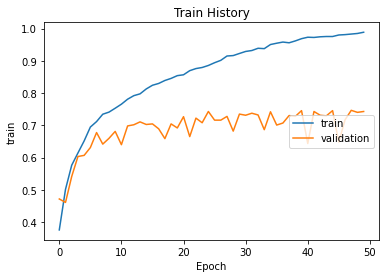

In [15]:
# 畫出train與test dataset 訓練過程的準確率
show_train_history(train_history, 'accuracy', 'val_accuracy')

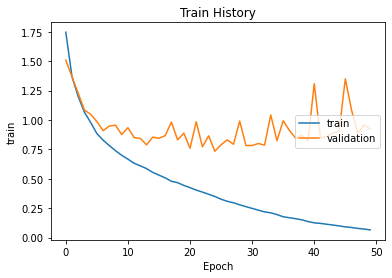

In [16]:
# 畫出train與test dataset訓練過程的誤差率
show_train_history(train_history, 'loss', 'val_loss')

In [17]:
scores = model.evaluate(x_test, y_test)
scores[1]

44/44 [==============================] - 0s 5ms/step - loss: 0.8321 - accuracy: 0.7599


0.759856641292572